In [6]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import conflict
import analysis
import os
import networkx as nx

In [7]:
# read in all data
inputFile = '../data/TrajDataV2_20120729.txt'
trajectories = pd.read_csv('%s.csv' % inputFile, index_col='flightIndex')

rawPointConflicts = {}
pointConflicts = {}
parallelConflicts = {}
flights2Conflicts = {}
multiConflicts = {}
mindistance = 30.0
for mintime in range(1,61):
    name = "mindist%05.1f_mintime%03i" % (mindistance, mintime)
    
    rawPointConflictFile = '%s.%s.rawRawPointConflict.csv' % (inputFile, name)
    if os.path.exists(rawPointConflictFile):
        rawPointConflicts[mintime] = pd.read_csv(rawPointConflictFile, index_col='conflictIndex')
    pointConflictFile = '%s.%s.pointConflicts.csv' % (inputFile, name)
    if os.path.exists(pointConflictFile):
        pointConflicts[mintime] = pd.read_csv(pointConflictFile, index_col='conflictIndex')
        
    parallelConflictFile = '%s.%s.parallelConflicts.csv' % (inputFile, name)
    if os.path.exists(parallelConflictFile):
        parallelConflicts[mintime] = pd.read_csv(parallelConflictFile, index_col='parallelConflict')
    
    flights2ConflictsFile = '%s.%s.flights2Conflicts.h5' % (inputFile, name)
    if os.path.exists(flights2ConflictsFile):
        flights2Conflicts[mintime] = pd.read_hdf(flights2ConflictsFile, 'flights2Conflicts')

    multiConflictFile = '%s.%s.multiConflicts.csv' % (inputFile, name)
    if os.path.exists(multiConflictFile):
        multiConflicts[mintime] = pd.read_csv(multiConflictFile, index_col='multiConflictIndex')

In [9]:
%matplotlib inline

# Trajectories #

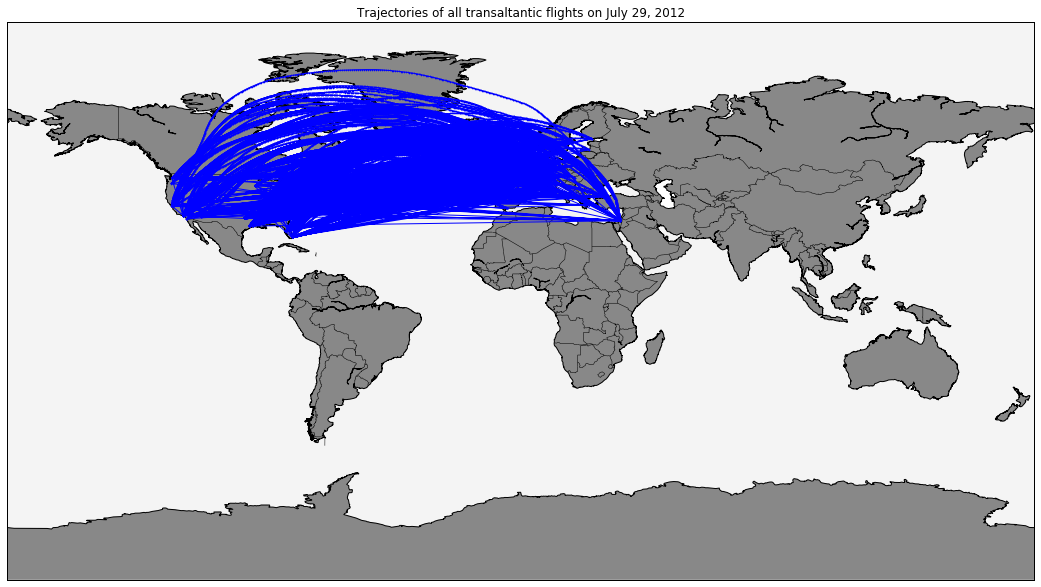

In [18]:
worldmap = analysis.prepareWorldMapPlot()
analysis.addTrajectories(worldmap, trajectories)
plt.title('Trajectories of all transaltantic flights on July 29, 2012');